In [1]:
from dotenv import load_dotenv
import os
import json
from googleapiclient import discovery

load_dotenv()
API_KEY = os.getenv("PCA_TOKEN")

In [2]:
# Initialisation du client
client = discovery.build(
    "commentanalyzer",
    "v1alpha1",
    developerKey=API_KEY,
    discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
    static_discovery=False,
)

# Exemple : une phrase de test
text = "I hate you, you're the worst."

analyze_request = {
    'comment': {'text': text},
    'requestedAttributes': {
        'TOXICITY': {},
        'INSULT': {},
        'PROFANITY': {},
        'IDENTITY_ATTACK': {},
        'THREAT': {}
    }
}

response = client.comments().analyze(body=analyze_request).execute()
print("Toxicity : ", response['attributeScores']['TOXICITY']['summaryScore']['value'])
print("Insult : ", response['attributeScores']['INSULT']['summaryScore']['value'])
print("Profanity : ", response['attributeScores']['PROFANITY']['summaryScore']['value'])
print("Identity Attack : ", response['attributeScores']['IDENTITY_ATTACK']['summaryScore']['value'])
print("Threat : ", response['attributeScores']['THREAT']['summaryScore']['value'])

Toxicity :  0.8299589
Insult :  0.65129566
Profanity :  0.39409557
Identity Attack :  0.28622448
Threat :  0.05947323


In [ ]:
import pandas as pd
df_lyrics = pd.read_excel("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\Projet-DEBIAR---Labellisation-and-hidden-states\\translated_lyrics.xlsx", sheet_name="Sheet1")

df_lyrics_toxicities = pd.DataFrame()
df_lyrics_toxicities['track_name'] = df_lyrics['track_name']
df_lyrics_toxicities['track_artist'] = df_lyrics['track_artist']
df_lyrics_toxicities['english_lyrics'] = df_lyrics['english_lyrics']

del df_lyrics
print(df_lyrics_toxicities.head())
df_lyrics_toxicities['toxicity'] = None
df_lyrics_toxicities['insult'] = None
df_lyrics_toxicities['profanity'] = None
df_lyrics_toxicities['identity_attack'] = None
df_lyrics_toxicities['threat'] = None
df_lyrics_toxicities['sexually_explicit'] = None
df_lyrics_toxicities['flirtation'] = None

output_PATH = "C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\Projet-DEBIAR---Labellisation-and-hidden-states\\lyrics_toxicities.xlsx"

                                          track_name    track_artist  \
0                                             Poison  Bell Biv DeVoe   
1  Baby It's Cold Outside (feat. Christina Aguilera)     CeeLo Green   
2                                         Dumb Litty            KARD   
3                                            Soldier        James TW   
4                                        Satisfy You           Diddy   

                                      english_lyrics  
0  NA Yeah, Spyderman and Freeze in full effect U...  
1  I really can't stay Baby it's cold outside I'v...  
2  Get out of my business. You can't stop me from...  
3  Hold your breath, don't look down, keep trying...  
4  All I want is somebody who's gonna love me for...  


In [ ]:
import time

for index, row in df_lyrics_toxicities.iterrows():
    text = row['english_lyrics']
    analyze_request = {
        'comment': {'text': text},
        'requestedAttributes': {
            'TOXICITY': {},
            'INSULT': {},
            'PROFANITY': {},
            'IDENTITY_ATTACK': {},
            'THREAT': {},
            'SEXUALLY_EXPLICIT': {},
            'FLIRTATION': {}
        }
    }
    

    time.sleep(1)   # Pause d'une seconde pour éviter de dépasser les limites de l'API
    try:
        response = client.comments().analyze(body=analyze_request).execute()
    except Exception as e:
        print(f"Error processing row {index+2}, \"{row['track_name']}\": {e}")
        continue
    
    df_lyrics_toxicities.at[index, 'toxicity'] = response['attributeScores']['TOXICITY']['summaryScore']['value']
    df_lyrics_toxicities.at[index, 'insult'] = response['attributeScores']['INSULT']['summaryScore']['value']
    df_lyrics_toxicities.at[index, 'profanity'] = response['attributeScores']['PROFANITY']['summaryScore']['value']
    df_lyrics_toxicities.at[index, 'identity_attack'] = response['attributeScores']['IDENTITY_ATTACK']['summaryScore']['value']
    df_lyrics_toxicities.at[index, 'threat'] = response['attributeScores']['THREAT']['summaryScore']['value']
    df_lyrics_toxicities.at[index, 'sexually_explicit'] = response['attributeScores']['SEXUALLY_EXPLICIT']['summaryScore']['value']
    df_lyrics_toxicities.at[index, 'flirtation'] = response['attributeScores']['FLIRTATION']['summaryScore']['value']

    if index % 10 == 0:
        print(f"Processing row {index}/{len(df_lyrics_toxicities)}")
        df_lyrics_toxicities.to_excel(output_PATH, index=False)
        if index % 50 == 0: #afficher la ligne actuelle
            print(df_lyrics_toxicities.iloc[index])

df_lyrics_toxicities.to_excel(output_PATH, index=False)

Processing row 0/1502
track_name                                                    Poison
track_artist                                          Bell Biv DeVoe
english_lyrics     NA Yeah, Spyderman and Freeze in full effect U...
toxicity                                                     0.21241
insult                                                      0.048521
profanity                                                   0.186638
identity_attack                                             0.019877
threat                                                      0.022854
Name: 0, dtype: object
Processing row 10/1502
Processing row 20/1502
Processing row 30/1502
Processing row 40/1502
Processing row 50/1502
track_name                                                     Morph
track_artist                                       Twenty One Pilots
english_lyrics     Move! Can't stop thinking about if and when I ...
toxicity                                                    0.110002
insult      

In [7]:
#remove empty lines in
df_lyrics_toxicities = df_lyrics_toxicities.dropna(subset=['toxicity'])
df_lyrics_toxicities.to_excel(output_PATH, index=False)

In [16]:
#on récupère les données labellisées d'un modèle données afin de faire un histogramme des toxicités des paroles de chansons par label
model_name = "unsloth/Mistral-Small-Instruct-2409-bnb-4bit"
#model_name = "unsloth/Phi-4-mini-instruct-bnb-4bit"
#model_name = "unsloth/DeepSeek-R1-Distill-Qwen-1.5B-bnb-4bit"
#model_name = "unsloth/Qwen2-7B-Instruct-bnb-4bit"
#model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit"

modele_str = model_name.split('/')[-1]
df_labeled_lyrics = pd.read_excel(f"C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\Projet-DEBIAR---Labellisation-and-hidden-states\\labeled_lyrics_gender_{modele_str}.xlsx", sheet_name="Sheet1")

df_lyrics_toxicities['label'] = None

for index, row in df_lyrics_toxicities.iterrows():
    matching_rows = df_labeled_lyrics[(df_labeled_lyrics['track_name'] == row['track_name']) & (df_labeled_lyrics['track_artist'] == row['track_artist'])]
    if matching_rows.empty:
        continue
    df_lyrics_toxicities.at[index, 'label'] = matching_rows.iloc[0]['genre_LLM']

df_lyrics_toxicities.to_excel(output_PATH, index=False)

         toxicity    insult  profanity  identity_attack    threat
label                                                            
female   0.253952  0.100131   0.221653         0.040777  0.059259
male     0.370378  0.209075   0.347110         0.148258  0.132137
neutral  0.218120  0.088842   0.168670         0.038567  0.073720


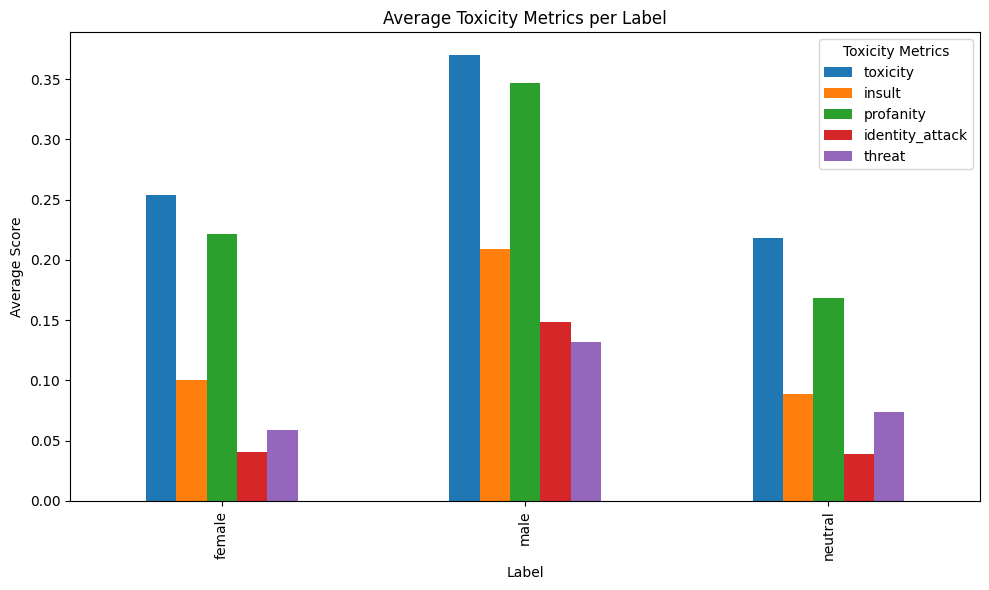

In [17]:
cols = ['toxicity', 'insult', 'profanity', 'identity_attack', 'threat']

df_lyrics_toxicities[cols] = df_lyrics_toxicities[cols].apply(pd.to_numeric, errors='coerce')

df_for_group = df_lyrics_toxicities.dropna(subset=['label'])

average_toxicity_per_label = df_for_group.groupby('label')[cols].mean()
print(average_toxicity_per_label)

import matplotlib.pyplot as plt
average_toxicity_per_label.plot(kind='bar', figsize=(10, 6))
plt.title('Average Toxicity Metrics per Label')
plt.xlabel('Label')
plt.ylabel('Average Score')
plt.legend(title='Toxicity Metrics')
plt.tight_layout()
plt.savefig(f"average_toxicity_per_label_{modele_str}.png")
plt.show()